# H-1B Visa Petition
## 02:Preprocessing

**Author:** Prasoon Karmacharya

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from imblearn.pipeline import  Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

RANDOM_STATE = 42

In [2]:
data = pd.read_csv("../assets/data/893_1632_bundle_archive.zip")

In [3]:
df = data.copy()

### Data Dictionary
* CASE_STATUS - status of the application
* EMPLOYER_NAME - the name of the employer as registered in the H-1B Visa application
* SOC_NAME - the occupation code for the employment
* JOB_TITLE - the job title for the employment
* FULL_TIME_POSITION - whether the application is for a full-time position of for a part-time position
* PREVAILING_WAGE - the most frequent wage for the corresponding role as filled in the Visa application
* YEAR - the application year
* WORKSITE - the address of the employer worksite
* lon - longitude of the employer worksite
* lat - latitude of the employer worksite

In [4]:
df.isnull().sum()

Unnamed: 0                 0
CASE_STATUS               13
EMPLOYER_NAME             59
SOC_NAME               17734
JOB_TITLE                 43
FULL_TIME_POSITION        15
PREVAILING_WAGE           85
YEAR                      13
WORKSITE                   0
lon                   107242
lat                   107242
dtype: int64

In [5]:
df.CASE_STATUS.value_counts(normalize=True)

CERTIFIED                                             8.711643e-01
CERTIFIED-WITHDRAWN                                   6.749799e-02
DENIED                                                3.142306e-02
WITHDRAWN                                             2.990862e-02
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED    4.995928e-06
REJECTED                                              6.661238e-07
INVALIDATED                                           3.330619e-07
Name: CASE_STATUS, dtype: float64

* Remove columns

In [6]:
columns_to_drop = ["Unnamed: 0", "lon", "lat"]
df.drop(columns=columns_to_drop, inplace=True)

### Prepare Target Labels
* Remove WITHDRAWN, PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED, REJECTED, INVALIDATED
* Binarize CERTIFIED (1), DENIED (0)

In [7]:
df.drop(df.loc[(df["CASE_STATUS"]=="WITHDRAWN")|(df["CASE_STATUS"]=="PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED")|(df["CASE_STATUS"]=="INVALIDATED")].index, inplace=True)

* Removing records with missing CASE_STATUS

In [8]:
null_columns=df.columns[df.isnull().any()]
df.drop(df[df["CASE_STATUS"].isnull()][null_columns].index,inplace=True)

* Create binary column CERTIFIED:1, CERTIFIED-WITHDRAWN:1, DENIED:0, REJECTED":0

In [9]:
df["CASE_STATUS"] = df["CASE_STATUS"].map({"CERTIFIED":1, 
                                           "CERTIFIED-WITHDRAWN":1, 
                                           "DENIED":0, 
                                           "REJECTED":0})

* Remove instance with missing employer name

In [10]:
df.drop(df[df["EMPLOYER_NAME"].isnull()][null_columns].index,inplace=True)

In [11]:
df.isna().sum()

CASE_STATUS               0
EMPLOYER_NAME             0
SOC_NAME              17072
JOB_TITLE                10
FULL_TIME_POSITION        1
PREVAILING_WAGE          53
YEAR                      0
WORKSITE                  0
dtype: int64

* There was one instance where a case was denied and FULL_TIME_POSITION had missing value, based on other information for this information, I decided to impute the missing value with "Y"

In [12]:
df.loc[(df["CASE_STATUS"]==0) & df["FULL_TIME_POSITION"].isnull(), "FULL_TIME_POSITION"] = "Y"

In [13]:
df.isnull().sum()

CASE_STATUS               0
EMPLOYER_NAME             0
SOC_NAME              17072
JOB_TITLE                10
FULL_TIME_POSITION        0
PREVAILING_WAGE          53
YEAR                      0
WORKSITE                  0
dtype: int64

* Imputing prevailing wage with mean prevailing wage if the case was denied.

In [14]:
df.loc[(df["CASE_STATUS"]==0) & df["PREVAILING_WAGE"].isnull(), "PREVAILING_WAGE"] = df["PREVAILING_WAGE"].mean()

In [15]:
df.isnull().sum()

CASE_STATUS               0
EMPLOYER_NAME             0
SOC_NAME              17072
JOB_TITLE                10
FULL_TIME_POSITION        0
PREVAILING_WAGE           0
YEAR                      0
WORKSITE                  0
dtype: int64

* Imputing JOB_TITLE
    * If SOC_NAME and JOB_TITLE is missing 
        * then drop the row
    * else 
        * JOB_TITLE imputed with SOC_NAME
    

In [16]:
df.drop(df.loc[(df["CASE_STATUS"]==0) & df["JOB_TITLE"].isnull() & df["SOC_NAME"].isnull()].index, inplace=True)

In [17]:
df.loc[(df["CASE_STATUS"]==0) & df["JOB_TITLE"].isnull(), "JOB_TITLE"] = df["SOC_NAME"]

In [18]:
df.isnull().sum()

CASE_STATUS               0
EMPLOYER_NAME             0
SOC_NAME              17068
JOB_TITLE                 3
FULL_TIME_POSITION        0
PREVAILING_WAGE           0
YEAR                      0
WORKSITE                  0
dtype: int64

### Imputing SOC_NAME
    * If CASE_STATUS == 1 and SOC_NAME is missing 
        * then drop the row
    * else 
        * SOC_NAME imputed with JOB_TITLE

In [19]:
df.drop(df.loc[(df["CASE_STATUS"]==1) & df["SOC_NAME"].isnull()].index, inplace=True)

In [20]:
df.loc[(df["CASE_STATUS"]==0) & df["SOC_NAME"].isnull(), "SOC_NAME"] = df["JOB_TITLE"]

In [21]:
df.isnull().sum()

CASE_STATUS           0
EMPLOYER_NAME         0
SOC_NAME              0
JOB_TITLE             2
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
WORKSITE              0
dtype: int64

### Imputing JOB_TITLE
    * If CASE_STATUS == 1 and JOB_TITLE is missing 
        * then drop the row
    * else 
        * JOB_TITLE imputed with SOC_NAME

In [22]:
df.drop(df.loc[(df["CASE_STATUS"]==1) & df["JOB_TITLE"].isnull()].index, inplace=True)

In [23]:
df.loc[(df["CASE_STATUS"]==0) & df["JOB_TITLE"].isnull(), "JOB_TITLE"] = df["SOC_NAME"]

In [24]:
df.isnull().sum()

CASE_STATUS           0
EMPLOYER_NAME         0
SOC_NAME              0
JOB_TITLE             0
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
WORKSITE              0
dtype: int64

In [25]:
print(f"Percentage of data removed from the original dataframe: {round(((data.shape[0] - df.shape[0])/data.shape[0])*100, 2)} %")

Percentage of data removed from the original dataframe: 3.54 %


In [26]:
df.CASE_STATUS.value_counts(normalize=True)

1    0.967426
0    0.032574
Name: CASE_STATUS, dtype: float64

### Feature Engineering

* Binarizing FULL_TIME_POSITION

In [27]:
df["FULL_TIME_POSITION"] = df["FULL_TIME_POSITION"].map({"Y": 1, "N": 0}).astype(int)

In [28]:
df.dtypes

CASE_STATUS             int64
EMPLOYER_NAME          object
SOC_NAME               object
JOB_TITLE              object
FULL_TIME_POSITION      int64
PREVAILING_WAGE       float64
YEAR                  float64
WORKSITE               object
dtype: object

* Label Encoding Year column

In [29]:
from sklearn.preprocessing import LabelEncoder

In [30]:
le = LabelEncoder()
df["YEAR_coded"] = le.fit_transform(df["YEAR"])
df[["YEAR", "YEAR_coded"]].tail(5)

df["SOC_NAME_coded"] = le.fit_transform(df["SOC_NAME"])
df[["SOC_NAME", "SOC_NAME_coded"]].tail(5)


,SOC_NAME,SOC_NAME_coded
3002369,Instructional Coordinators,1269
3002378,Accountants and Auditors,112
3002383,Computer Programmers,572
3002389,Sales Engineers,2209
3002392,Architectural and Civil Drafters,157


### Export Cleaned Data

In [31]:
df.to_pickle("../assets/data/cleaned_h1b.pkl")

### Feature Selection

In [34]:
feature_cols = ['FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR_coded', 'SOC_NAME_coded']
target_col = ['CASE_STATUS']

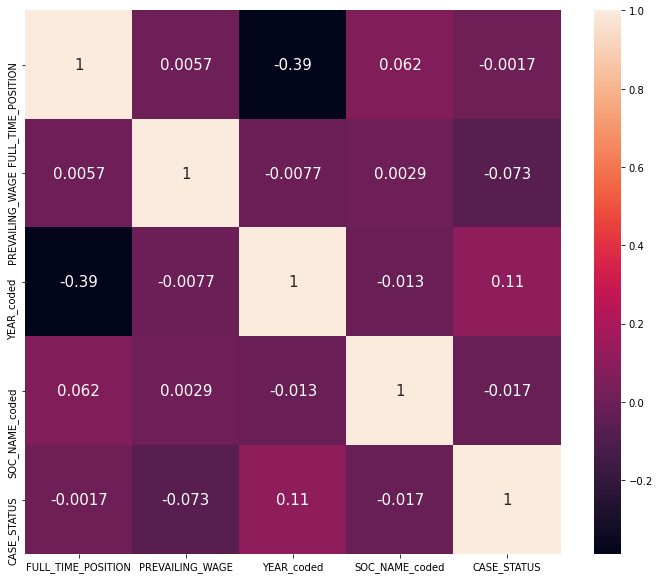

In [35]:
plt.figure(figsize=(12,10))
sns.heatmap(df[feature_cols + target_col].corr(), annot=True, annot_kws={'size' : 15});
